In [1]:
import numpy as np
import pandas as pd
import FlowCytometryTools as flow
import matplotlib.pyplot as plt

%matplotlib inline

### Data Import
Data handling: [http://eyurtsev.github.io/FlowCytometryTools/tutorial.html](http://eyurtsev.github.io/FlowCytometryTools/tutorial.html)

In [2]:
# Loading a file
datafile = "data/JF2017-01-06-B.0006.fcs"
sample = flow.FCMeasurement(ID='MG1655_sfGFP_mRFP1', datafile=datafile)

In [3]:
# Examining channels in the file
print sample.channel_names

(u'HDR-T', u'FSC-A', u'FSC-H', u'FSC-W', u'SSC-A', u'SSC-H', u'SSC-W', u'Y2-A', u'Y2-H', u'Y2-W', u'B1-A', u'B1-H', u'B1-W')


In [4]:
# YourSample.data returns a pandas dataframe with the raw data for each read
# I gatered 10k reads, 13 channels
print sample.data.shape

(10000, 13)


In [5]:
# And here's some data
print sample.data[['Y2-A', 'FSC-A']][:10]

          Y2-A         FSC-A
0  5306.313477   2721.044922
1  4736.391602  11533.376953
2    29.223442   3357.985352
3    17.695936  -6541.075195
4     4.721963   3233.231201
5  6466.929688   4459.637695
6  7095.660645  11265.457031
7  7982.730469   1869.270264
8  4455.803223   -294.199066
9  8064.943359  -2264.389648


In [6]:
# For retrieving the median
print sample.data['Y2-A'].median()

5442.88183594


### Plotting
Plotting gallery: [http://eyurtsev.github.io/FlowCytometryTools/gallery.html](http://eyurtsev.github.io/FlowCytometryTools/gallery.html)

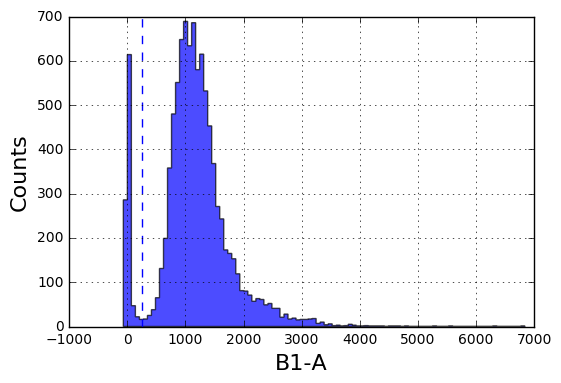

In [7]:
sample.plot('B1-A', color='blue', alpha=0.7, bins=100, grid=True)
plt.axvline(250, c="blue", linestyle="--")
plt.savefig("fig1a.png")

From the documentation: "Rather than having this transformation applied automatically and without your knowledge, this package provides a few of the common transformations (e.g., hlog, tlog), but ultimately leaves it up to you to decide how to manipulate your data. In the hlog transformation, the parameter b controls the location where the transformation shifts from linear to log. The optimal value for this parameter depends on the range of your data. For smaller ranges, try smaller values of b. So if your population doesn’t show up well, just adjust b."

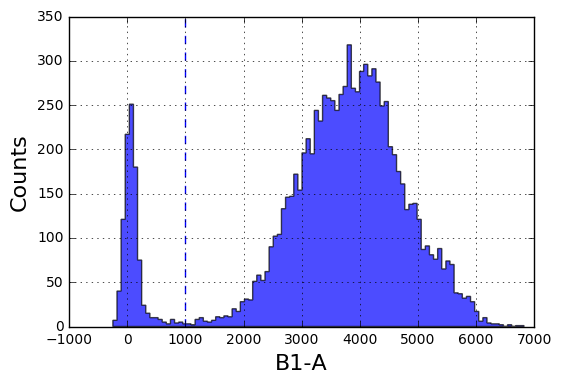

In [8]:
tsample = sample.transform('hlog',channels=['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Y2-A', 'Y2-H', 'Y2-W', 'B1-A', 'B1-H', 'B1-W'], b=500.0)
tsample.plot('B1-A', color='blue', alpha=0.7, bins=100, grid=True)
plt.axvline(1000, c="blue", linestyle="--")


### Data labeling

In [9]:
## I'm going to use untransformed data for the supervised learning. Transformation just stretch the data but shouldn't 
## change the results.

# Setting an arbitrary threshold for fluorescent and non-fluorescent stuff.
threshold = 250

# Classifying based on threshold
Object_Type = np.array([])
for i in sample.data["B1-A"]:
    if i > threshold:
        Object_Type = np.append(Object_Type, 1)
    else:
        Object_Type = np.append(Object_Type, 9)
data = sample.data
data["Object_Type"] = Object_Type
data.head()

,HDR-T,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,Y2-A,Y2-H,Y2-W,B1-A,B1-H,B1-W,Object_Type
0,21.537766,2721.044922,5611.010742,63563.023438,5568.997070,4110.853027,177564.015625,5306.313477,3524.106689,197357.562500,1143.540771,617.507446,242727.718750,1.0
1,67.674721,11533.376953,10393.686523,145444.328125,3277.630615,2735.080322,157072.390625,4736.391602,3436.684814,180641.625000,997.152588,669.475952,195225.515625,1.0
2,91.303741,3357.985352,9336.948242,47139.371094,3384.410645,2674.267822,165877.734375,29.223442,98.610855,38843.339844,19.239727,99.402077,25369.585938,9.0
3,96.068352,-6541.075195,3363.389648,-254907.078125,5206.671387,4185.524902,163049.765625,17.695936,74.761513,31024.542969,0.721177,106.087509,891.020020,9.0
4,133.085709,3233.231201,7134.643555,59398.351562,4759.702637,3840.285889,162452.421875,4.721963,80.450211,7693.170410,28.822926,61.786156,61144.417969,9.0


In [10]:
noncells = data[data["Object_Type"] == 9] 
noncells["B1-A"].max()

244.94321

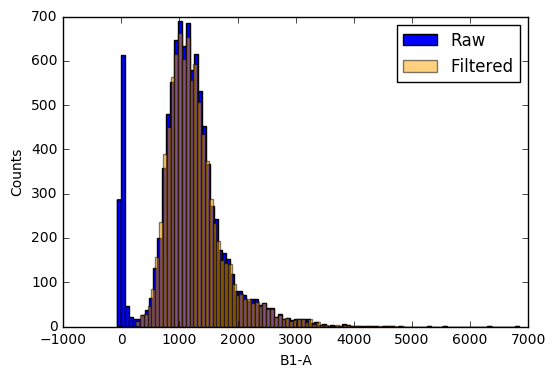

In [11]:
# here's what the manual cleaning did
data_preprocessed = data[data["Object_Type"] == 1] 
plt.hist(data["B1-A"], bins= 100, label="Raw");
plt.hist(data_preprocessed["B1-A"], bins= 100, alpha= 0.5, color="orange", label = "Filtered");
plt.ylabel("Counts")
plt.xlabel("B1-A")
plt.legend()

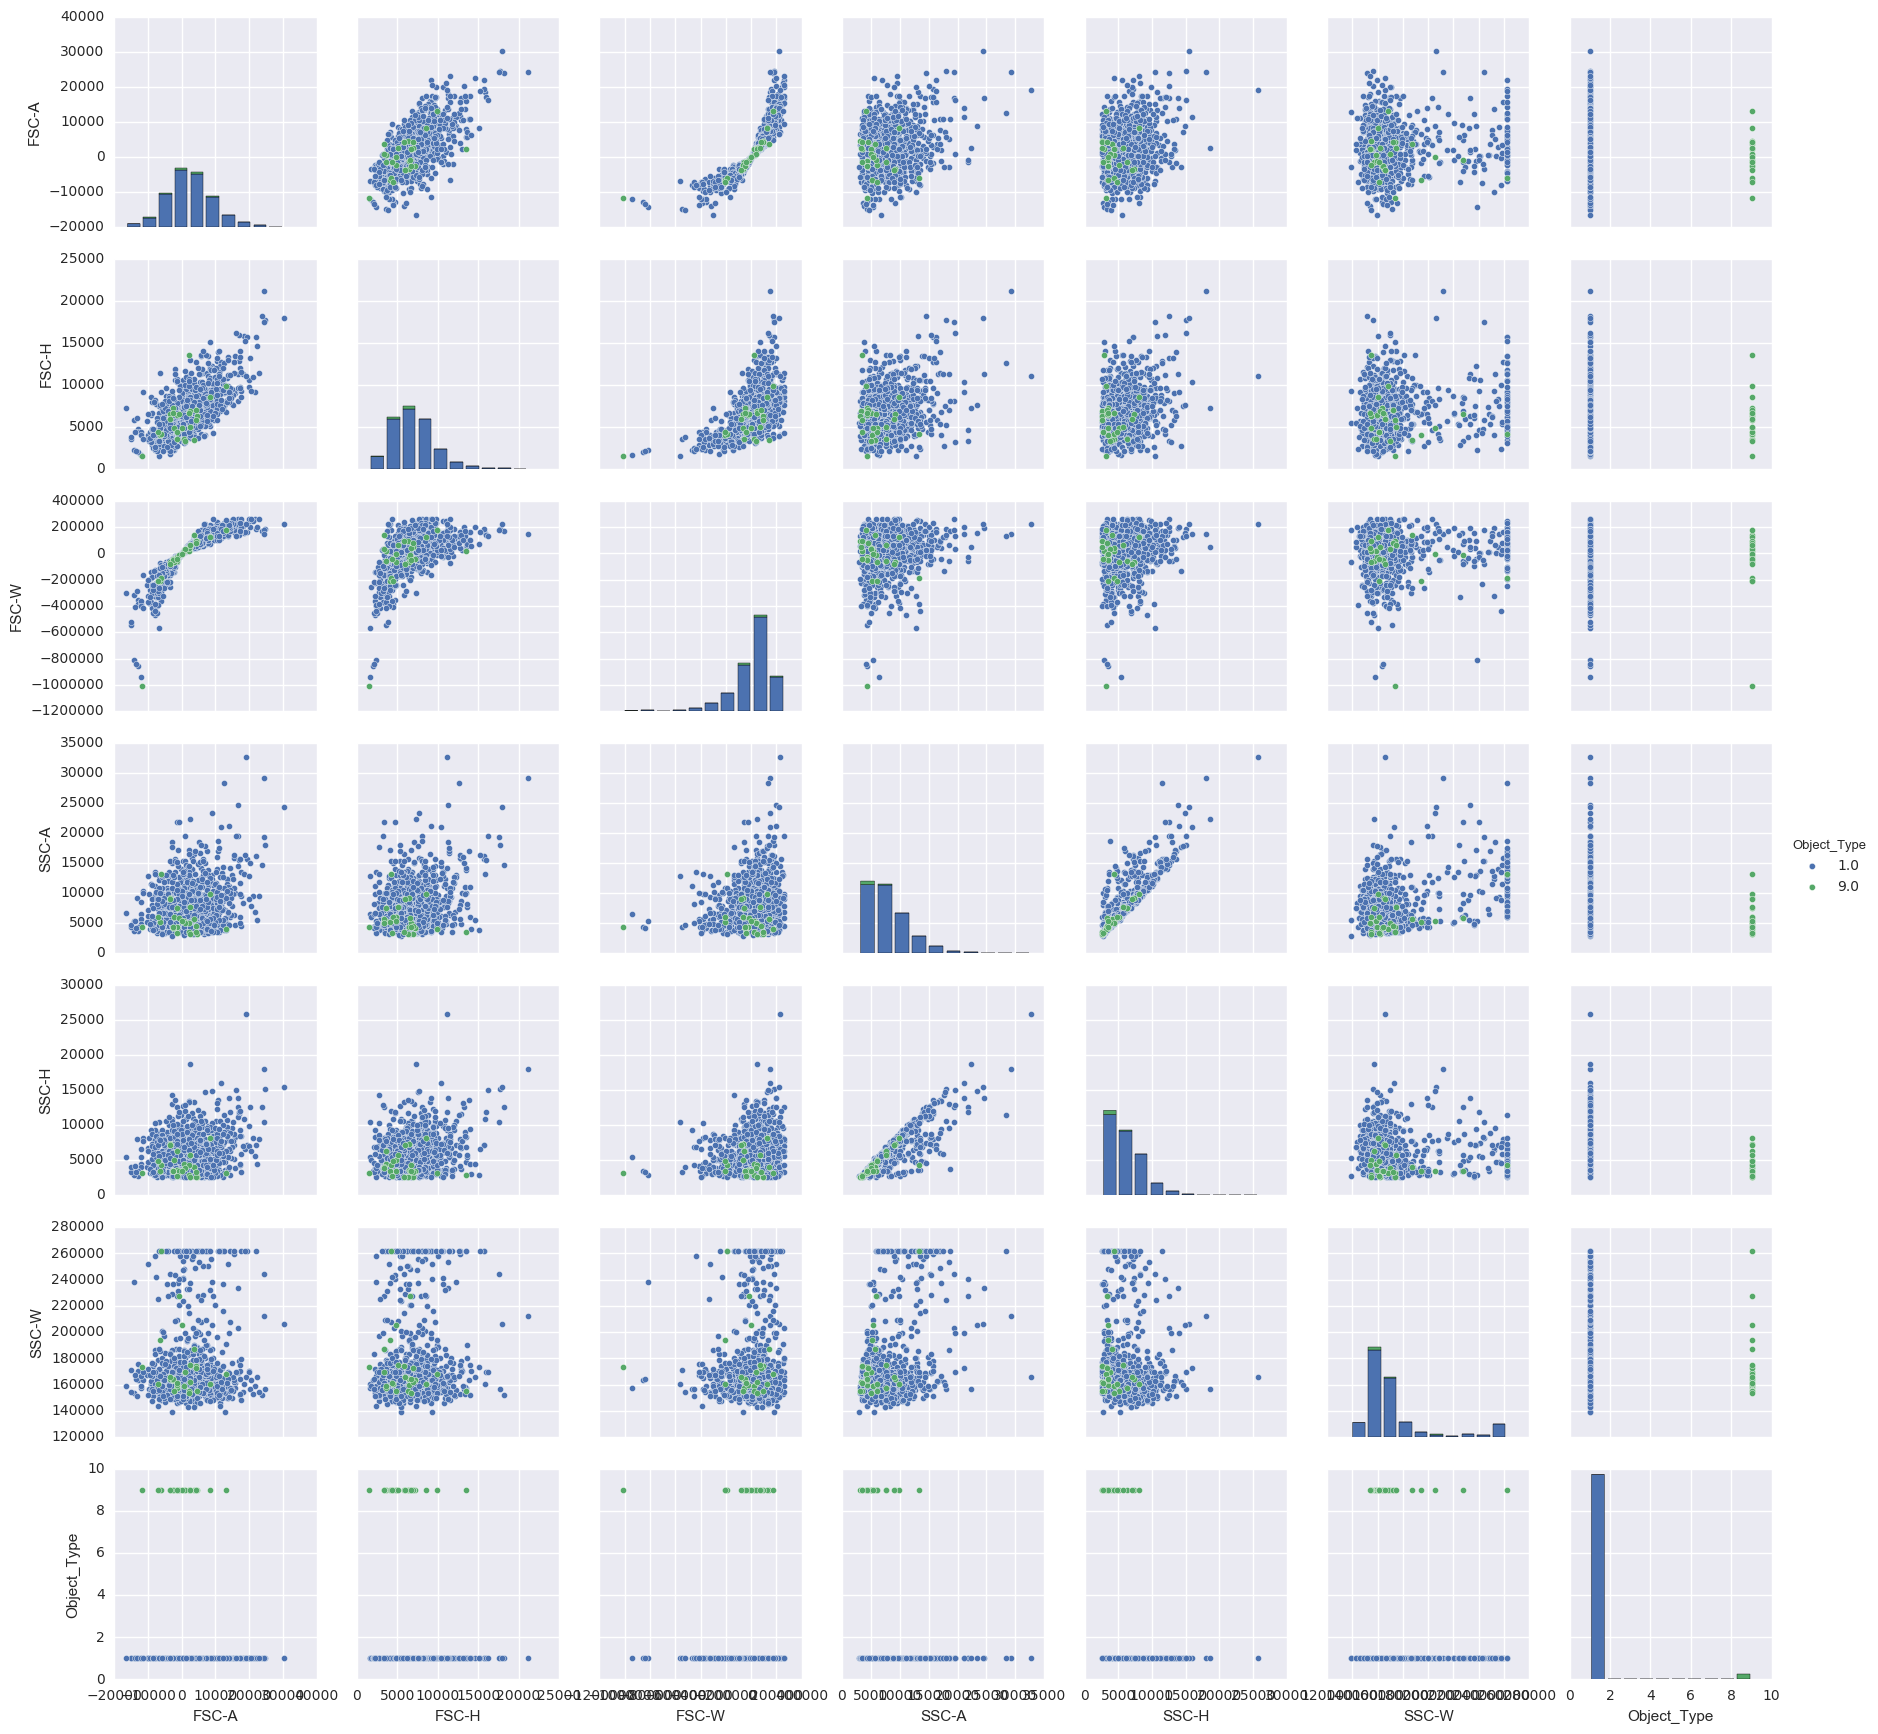

In [12]:
import seaborn as sns

## Plotting relationship between each parameter that we'll use in machine learning
channels_plot = list(tsample.channel_names[1:7]) + ["Object_Type"]
data_plots = data[channels_plot]

sns.pairplot(data_plots[9000:], hue="Object_Type")
plt.savefig("fig1b.png")

### Generating data for supervised learning

In [13]:
# Using supervised learning with all the scatter measurements, non transformed data
X = sample.data[list(sample.channel_names[1:7])]

In [14]:
X[:10]

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W
0,2721.044922,5611.010742,63563.023438,5568.997070,4110.853027,177564.015625
1,11533.376953,10393.686523,145444.328125,3277.630615,2735.080322,157072.390625
2,3357.985352,9336.948242,47139.371094,3384.410645,2674.267822,165877.734375
3,-6541.075195,3363.389648,-254907.078125,5206.671387,4185.524902,163049.765625
4,3233.231201,7134.643555,59398.351562,4759.702637,3840.285889,162452.421875
5,4459.637695,6110.441895,95661.437500,6132.524902,5203.037598,154487.125000
6,11265.457031,10336.461914,142852.171875,3344.814941,2670.672607,164157.734375
7,1869.270264,10825.398438,22632.792969,11768.268555,9451.333984,163203.468750
8,-294.199066,4043.216064,-9537.274414,4447.352539,3454.984375,168719.546875
9,-2264.389648,6595.055176,-45003.125000,12359.852539,9763.746094,165923.062500


In [15]:
y = data["Object_Type"]
y[:10]

0    1.0
1    1.0
2    9.0
3    9.0
4    9.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: Object_Type, dtype: float64

### Prototyping supervised learning code

In [16]:
from sklearn.cross_validation import train_test_split

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


In [17]:
from progressbar import ProgressBar

In [18]:
def cross_val_class_accuracy(model, X, y, test_f , reps):
    accuracy = np.array([])
    pbar = ProgressBar()
    for i in pbar(range(reps)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_f)
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        accuracy = np.append(accuracy, np.mean(prediction == y_test))
    return np.mean(accuracy) 

In [19]:
## First, let's try to use all scatter measurements to classify, using a KNN
models = [KNeighborsClassifier(n_neighbors=10), KNeighborsClassifier(n_neighbors=44)]

In [20]:
## How do the different models perform in terms of cross-validation accuracy?
acc = np.array([])
for model in models:
    print "Using model: " + str(model)
    acc = np.append(acc, cross_val_class_accuracy(model, X, y, 0.8 , 100))

Using model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')


100% |########################################################################|


Using model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=44, p=2,
           weights='uniform')


100% |########################################################################|


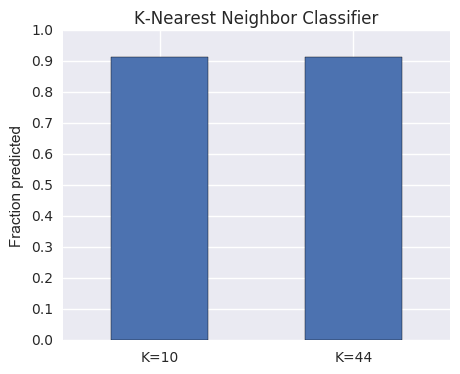

In [21]:
ind = np.arange(len(models))
width = 0.5
fig, ax = plt.subplots(figsize=(5,4))
ax.bar(ind, acc, width)
ax.set_ylabel('Fraction predicted')
ax.set_xticks(ind + width / 2)
ax.set_xticks(ind + width / 2)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticklabels(["K=10", "K=44"])
plt.xlim(-0.25, 1.75)
ax.set_title("K-Nearest Neighbor Classifier")
plt.savefig("fig1c.png")

In [22]:
# let's save a model for later use.
def generate_model(classifier, X, y, test_f , reps):
    accuracy = np.array([])
    pbar = ProgressBar()
    for i in pbar(range(reps)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_f)
        classifier.fit(X_train, y_train)
        prediction = classifier.predict(X_test)
        accuracy = np.append(accuracy, np.mean(prediction == y_test))
    print np.mean(accuracy) 
    return classifier

model = generate_model(KNeighborsClassifier(n_neighbors=44), X, y, 0.8 , 100)

0.91358


100% |########################################################################|


In [23]:
# Now let's try to see how if the classifier can be used to clean the data from non-cell reads.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=12)
prediction = model.predict(X_test)

test_index = X_test.index

test_sample = sample.data.ix[test_index]
test_sample["Predicted"] = prediction
test_sample.head()

,HDR-T,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,Y2-A,Y2-H,Y2-W,B1-A,B1-H,B1-W,Predicted
5669,248188.484375,10689.976562,11014.795898,127206.773438,6402.271973,5193.408691,161581.468750,6319.203613,4497.953613,184143.890625,1004.174011,718.604370,183159.328125,1.0
8800,258209.640625,-13814.034180,2779.548340,-651412.687500,12222.771484,10009.088867,160060.828125,9720.040039,6876.347168,185276.437500,1847.478760,1140.245117,212369.015625,1.0
3205,107081.312500,6393.004883,7996.675293,104786.539062,7058.407715,5767.076660,160420.890625,4091.868896,2944.994873,182115.578125,971.160522,637.839539,199567.359375,1.0
8731,257993.906250,2110.335693,10431.859375,26515.496094,3580.697998,3054.745605,153639.390625,3823.137451,2593.324707,193229.281250,840.230957,541.937195,203216.812500,1.0
6412,250509.312500,5232.054199,5714.686523,120002.351562,6224.822754,5197.496582,156979.406250,4459.555176,3141.373779,186072.359375,1034.647949,666.022461,203616.828125,1.0


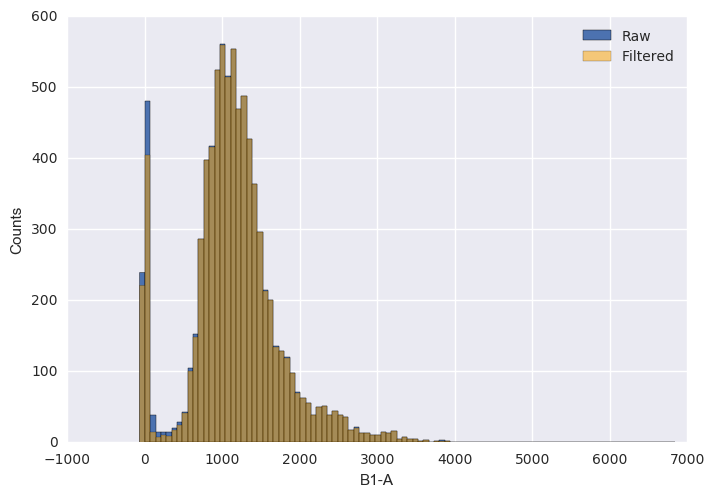

In [24]:
test_sample_preprocessed = test_sample[test_sample["Predicted"] == 1] 
plt.hist(test_sample["B1-A"], bins= 100, label = "Raw");
plt.hist(test_sample_preprocessed["B1-A"], bins= 100, alpha= 0.5, color="orange", label = "Filtered");
plt.ylabel("Counts")
plt.xlabel("B1-A")
plt.legend()
plt.savefig("fig1d.png")

### New metric: % non-cells cleaned

In [25]:
def generateModel(model, X_train, y_train):
    ## train model, using only scatter even if X has other stuff in it
    model_trained = model.fit(X_train[list(sample.channel_names[1:7])], y_train)
    return model_trained

def validateModel(model_trained, X_test, y_test):
    ## predict, using only scatter even if X has other stuff in it
    prediction = model_trained.predict(X_test[list(sample.channel_names[1:7])])
    accuracy = np.mean(prediction == y_test)
    return accuracy 

def evaluateCleaning(model_trained, X_test, y_test, plot):
    # Considering only non-cells
    y_test_noncells = y_test[y_test == 9]
    X_test_noncells = X_test.ix[y_test_noncells.index]
    # Predicting
    prediction = model_trained.predict(X_test_noncells[list(sample.channel_names[1:7])])
    accuracy = np.mean(prediction == y_test_noncells)
    # Computing % cleaned
    X_test_noncells["Prediction"] = prediction
    X_test_noncells_filtered = X_test_noncells[X_test_noncells["Prediction"] == 9]
    percentCleaned = 100 * (X_test_noncells_filtered.shape[0]/float(X_test_noncells.shape[0]))
    
    # plotting
    if plot == True:
        plt.hist(X_test_noncells["B1-A"], bins= 50, label = "Non-Cells in Sample");
        plt.hist(X_test_noncells_filtered["B1-A"], bins= 50, alpha= 0.5, color="orange", label = "Predicted Non-Cells");
        plt.ylabel("Counts")
        plt.xlabel("B1-A")
        plt.legend()
    
    return percentCleaned

def evaluateCleaning2(model_trained, X_test, y_test, plot):
    # Predicting
    prediction = model_trained.predict(X_test[list(sample.channel_names[1:7])])
    accuracy = np.mean(prediction == y_test)
    X_test["Prediction"] = prediction
    X_test["Object_Type"] = y_test
    
    # Computing % cleaned
    X_test_noncells = X_test[X_test["Object_Type"] == 9]
    X_test_noncells_filtered = X_test_noncells[X_test_noncells["Prediction"] == 9]
    percentCleaned = 100 * (X_test_noncells_filtered.shape[0]/float(X_test_noncells.shape[0]))
    
    # plotting
    if plot == True:
        X_test_noncells_wrongPrediction = X_test_noncells[X_test_noncells["Prediction"] == 1]
        plt.hist(X_test_noncells["B1-A"], bins=50, label = "Non-Cells in Sample");
        plt.hist(X_test_noncells_wrongPrediction["B1-A"], bins=50, color="orange", label = "False Non-Cells Predicted");
        plt.hist(X_test_noncells_filtered["B1-A"], bins=50, label = "True Non-Cells Predicted");
        plt.ylabel("Counts")
        plt.xlabel("B1-A")
        plt.legend()
    
    return percentCleaned
        

In [27]:
def modelPerformance(model, X, test_fract, reps):
    accuracy = np.array([])
    percentCleaned = np.array([])

    for i in range(reps):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_fract)
        model_trained = generateModel(model, X_train, y_train)
        accuracy = np.append(accuracy, validateModel(model_trained, X_test, y_test))
        percentCleaned = np.append(percentCleaned, evaluateCleaning(model_trained, X_test, y_test, plot=False))

    return np.mean(accuracy), np.mean(percentCleaned)

X = sample.data[list(sample.channel_names[1:7]) + ["B1-A"]]
reps = 100
test_fract = 0.5
model = KNeighborsClassifier(n_neighbors=44)

modelPerformance(model, X, test_fract, reps)

(0.91547000000000001, 18.65085288470582)

In [31]:
import types 

def compareModelPerformance(models, X, test_fract, reps, plot):
    accuracy_log = np.array([])
    percentCleaned_log = np.array([])
    
    if type(models) <> list: models = [models]
    
    for model in models:
        accuracy, percentCleaned = modelPerformance(model, X, test_fract, reps)
        accuracy_log = np.append(accuracy_log, accuracy)
        percentCleaned_log = np.append(percentCleaned_log, percentCleaned)
        
    if plot == True:
        print "Still coding plotting fuction"
        # plotting function
    return accuracy_log, percentCleaned_log

models = KNeighborsClassifier(n_neighbors=44)
compareModelPerformance(models, X, test_fract, reps, plot=True)

Still coding plotting fuction


(array([ 0.914958]), array([ 18.40327401]))

In [ ]:
# try Gaussian mixtures (evaluate each mixture as a separate gaussian population) 
# http://scikit-learn.org/stable/modules/mixture.html

In [ ]:
# New function to code: evaluate multiple models with PCA

In [ ]:
# Positive control: include RFP into X, does it improve?

In [ ]:
# make table / heatpmap of metric (% no cells cleaning) with all different models tested

In [ ]:
# New code: last line of sns summary plot to look at single parameters. Evaluate models with all the single parameters.

### Applying the model to a new sample

In [ ]:
# Opening a new file and checking that the threshold still works
datafile2 = "data/JF2017-01-06-B.0007.fcs"
sample2 = flow.FCMeasurement(ID='MG1655_sfGFP_mRFP1', datafile=datafile)
sample2.plot('B1-A', color='blue', alpha=0.7, bins=100, grid=True)
plt.axvline(250, c="blue", linestyle="--")

I will use the model to predict cells and non-cells, then look at the distribution of red fluorescence of the identified "cell" reads.
By using a second fluorescent reporter (different from the green one used for training the model), we will make sure that the results were not dependent on some specific feature of that fluorophore that tricked the classifier.
After filtering, we expect the reads close to zero fluorescence to be removed.

In [ ]:
sample2.plot('Y2-A', color='orange', alpha=0.7, bins=100, grid=True);

In [ ]:
X2 = sample2.data[list(sample2.channel_names[1:7])]
X2.head()

In [ ]:
prediction2 = model.predict(X2)
sample2_preprocessed = sample2.data
sample2_preprocessed["Object_Type"] = prediction2

# Now let's select only the cell reads
sample2_preprocessed = sample2_preprocessed[sample2_preprocessed["Object_Type"] == 1] 

In [ ]:
plt.hist(sample2["Y2-A"], bins= 100, label="Raw");
plt.hist(sample2_preprocessed["Y2-A"], bins= 100, alpha= 0.5, color="orange", label = "Filtered");
plt.ylabel("Counts")
plt.xlabel("Y2-A")
plt.legend()
plt.savefig("fig1e.png")

The model was able to clean some non-cells read, but not very well.

In [ ]:
plt.hist(sample2["B1-A"], bins= 100, label="Raw");
plt.hist(sample2_preprocessed["B1-A"], bins= 100, alpha= 0.5, color="orange", label = "Filtered");
plt.ylabel("Counts")
plt.xlabel("B1-A")
plt.legend()

### Plotting and comparison between classifiers
[Compare classifiers](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py)
[Plot decision boundaries](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py)

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler

def compareClassifiers(ClassifiersNames, classifiers, Xs, y, test_f):
    h = 1  # step size in the mesh
    datasets = []
    for X in Xs:
        datasets.append((X,y))
    
    figure = plt.figure(figsize=(27, 5))

    # iterate over datasets
    i = 1
    for ds_cnt, ds in enumerate(datasets):
        # preprocess dataset, split into training and test part
        X, y = ds
        x_label = X.columns[0]
        y_label = X.columns[1]
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_f, random_state=12)

        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        # just plot the dataset first
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        if ds_cnt == 0:
            ax.set_title("Input data")
        
        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.5)
        
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.5, marker = "*")
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        i += 1

        # iterate over classifiers
        for name, clf in zip(ClassifiersNames, classifiers):
            ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

            # Plot also the training points
            ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.5)
            # and testing points
            ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                       alpha=0.5, marker = "*")

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            ax.set_xticks(())
            ax.set_yticks(())
            ax.set_xlabel(x_label)

            if ds_cnt == 0:
                ax.set_title(name)
            ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                    size=15, horizontalalignment='right', color="white")
            i += 1

    plt.tight_layout()
    plt.savefig("Output.png")
    #plt.show()


In [87]:
# Generating pairwise combinations of scatter parameters
Xs = []
channels_names = list(sample.channel_names[1:7])
for i in range(len(channels_names)):
    for j in range(i+1, len(channels_names)):
        cols = [channels_names[i], channels_names[j]]
        Xs.append(sample.data[cols])

y = data["Object_Type"]        

classifiers = [KNeighborsClassifier(3), KNeighborsClassifier(10),DecisionTreeClassifier() ]
classifiers_names = ["Nearest Neighbors-3", "Nearest Neighbors-10", "DecisionTreeClassifier"]


compareClassifiers(classifiers_names, classifiers, Xs[0:2], y, 0.5)


NameError: name 'compareClassifiers' is not defined